# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [ ]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

File 'UCI HAR Dataset.zip' already there; not retrieving.



Archive:  UCI HAR Dataset.zip


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [ ]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [ ]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [ ]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [ ]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

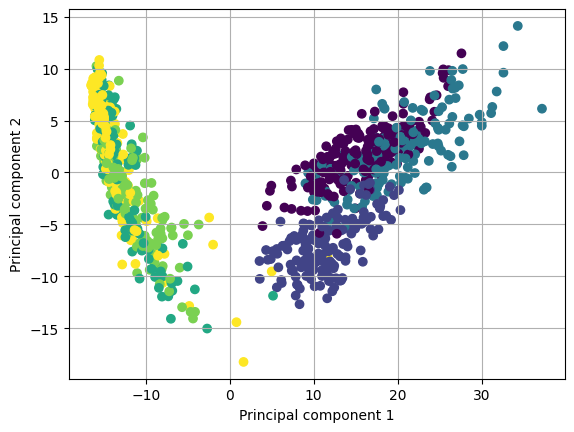

In [ ]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

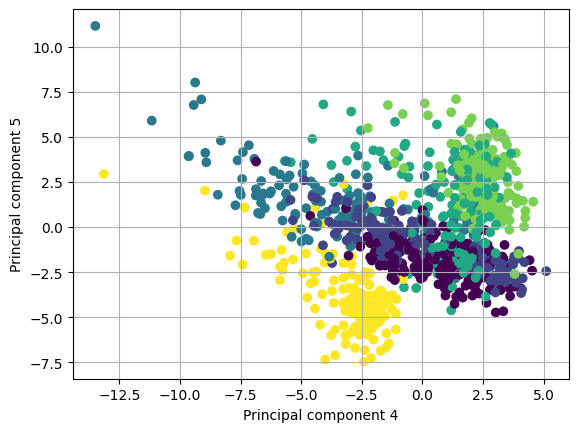

In [ ]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

In [ ]:
!pip install ucimlrepo

In [ ]:
import ucimlrepo as uci

In [ ]:
dataset = uci.fetch_ucirepo(id=186)

print(dataset.metadata.name, '\n')
print(dataset.metadata.abstract, '\n')
print(dataset.metadata.additional_info.summary, '\n')

Wine Quality 

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/). 

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to t

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

Попробуем сначала Gradient Boosting с дефолтными гиперпараметрами

In [ ]:
# YOUR CODE HERE

# Example: https://rpubs.com/burakh/har_xgb

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

model = LGBMClassifier()

model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45645
[LightGBM] [Info] Number of data points in the train set: 7352, number of used features: 179
[LightGBM] [Info] Start training from score -1.791216
[LightGBM] [Info] Start training from score -1.924514
[LightGBM] [Info] Start training from score -2.009071
[LightGBM] [Info] Start training from score -1.743436
[LightGBM] [Info] Start training from score -1.677246
[LightGBM] [Info] Start training from score -1.653513
Accuracy: 0.9117746861214795


Попробуем увеличить количество базовых моделей.

In [ ]:
model = LGBMClassifier(n_estimators=300)

model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45645
[LightGBM] [Info] Number of data points in the train set: 7352, number of used features: 179
[LightGBM] [Info] Start training from score -1.791216
[LightGBM] [Info] Start training from score -1.924514
[LightGBM] [Info] Start training from score -2.009071
[LightGBM] [Info] Start training from score -1.743436
[LightGBM] [Info] Start training from score -1.677246
[LightGBM] [Info] Start training from score -1.653513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

Accuracy увеличилось

Попробуем также увеличить максимальную глубину деревьев и количество листьев:

In [ ]:
model = LGBMClassifier(n_estimators=300, max_depth= 10, num_leaves= 128)

model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45645
[LightGBM] [Info] Number of data points in the train set: 7352, number of used features: 179
[LightGBM] [Info] Start training from score -1.791216
[LightGBM] [Info] Start training from score -1.924514
[LightGBM] [Info] Start training from score -2.009071
[LightGBM] [Info] Start training from score -1.743436
[LightGBM] [Info] Start training from score -1.677246
[LightGBM] [Info] Start training from score -1.653513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

Accuracy опять увеличилось.

## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

С помощью кроссвалидации будем подбирать наилучшие гиперпараметры.

In [ ]:
# YOUR CODE HERE
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 500),
    }

    model = LGBMClassifier(**param, verbosity=-1, random_state=42)

    accuracy = cross_val_score(model, X_train_pca, y_train, cv=5, scoring='accuracy').mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

best_model = LGBMClassifier(**study.best_trial.params, random_state=42)
best_model.fit(X_train_pca, y_train)
y_test_pred = best_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test,y_test_pred)
print(f"Test accuracy: {test_accuracy}")

[I 2024-11-17 22:09:02,021] A new study created in memory with name: no-name-d22818b9-fa00-446b-b438-31f79472c016
[I 2024-11-17 22:09:12,512] Trial 0 finished with value: 0.8763656543514756 and parameters: {'n_estimators': 127, 'max_depth': 18, 'learning_rate': 0.04542879117865848, 'num_leaves': 83, 'min_child_samples': 422}. Best is trial 0 with value: 0.8763656543514756.
[I 2024-11-17 22:09:22,073] Trial 1 finished with value: 0.9022083177254586 and parameters: {'n_estimators': 119, 'max_depth': 39, 'learning_rate': 0.41951063669934885, 'num_leaves': 69, 'min_child_samples': 258}. Best is trial 1 with value: 0.9022083177254586.
[I 2024-11-17 22:09:36,013] Trial 2 finished with value: 0.9050640732159622 and parameters: {'n_estimators': 183, 'max_depth': 46, 'learning_rate': 0.2850370473993775, 'num_leaves': 52, 'min_child_samples': 384}. Best is trial 2 with value: 0.9050640732159622.
[I 2024-11-17 22:09:46,379] Trial 3 finished with value: 0.8845267923620842 and parameters: {'n_estim

Test accuracy: 0.9304


In [ ]:
study.best_trial.params

{'n_estimators': 183,
 'max_depth': 46,
 'learning_rate': 0.2850370473993775,
 'num_leaves': 52,
 'min_child_samples': 384}

### Conclusion

Please, write down your thoughts on the experiment results:

...

С помощью optuna мы смогли оптимизировать гиперпараметры и получили accuracy лучше, чем подбором гиперпараметров вручную.

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [ ]:
import shap  # noqa: F401

explainer = shap.Explainer(best_model, X_train_pca)
shap_values = explainer(X_train_pca)

100%|===================| 44105/44112 [19:01<00:00]        

Будем изображать графики для каждого класса, который может предсказывать модель.

Рассмотрим для первого предсказания:

WALKING


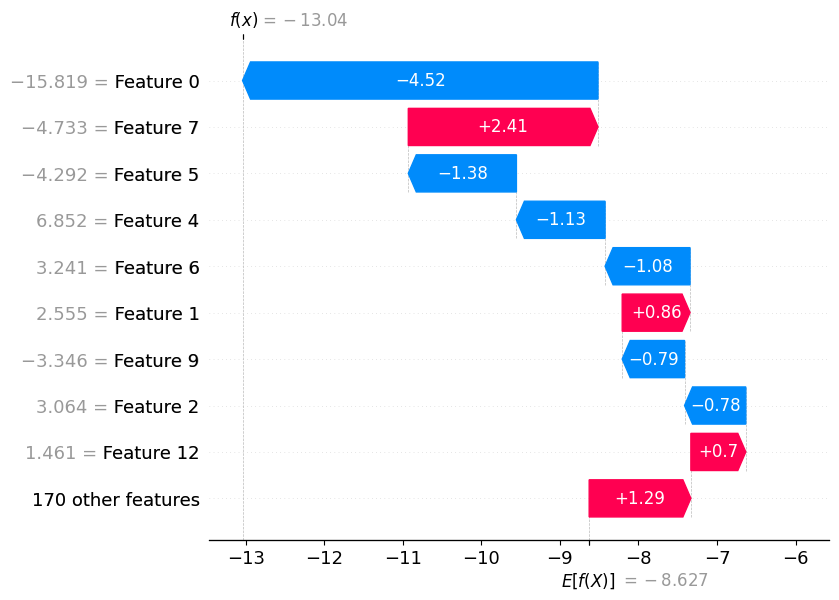

WALKING_UPSTAIRS


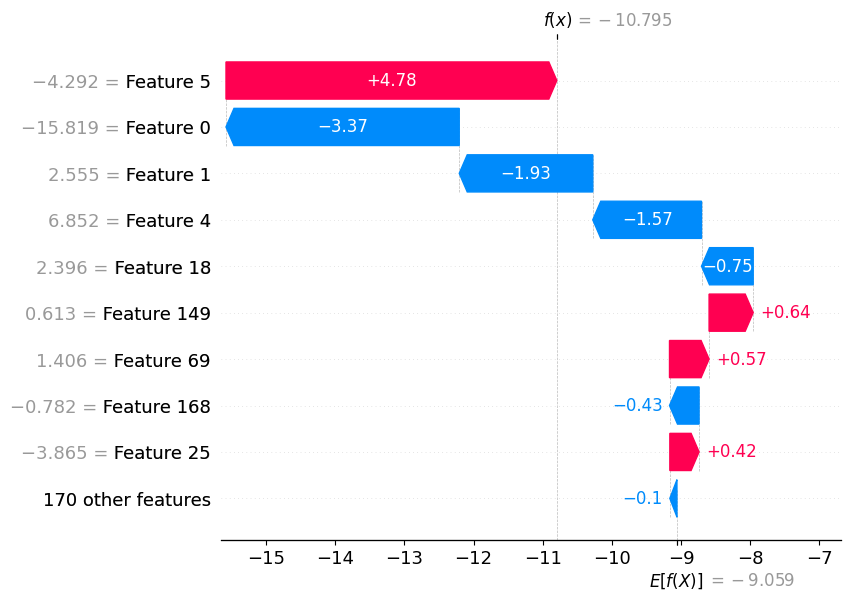

WALKING_DOWNSTAIRS


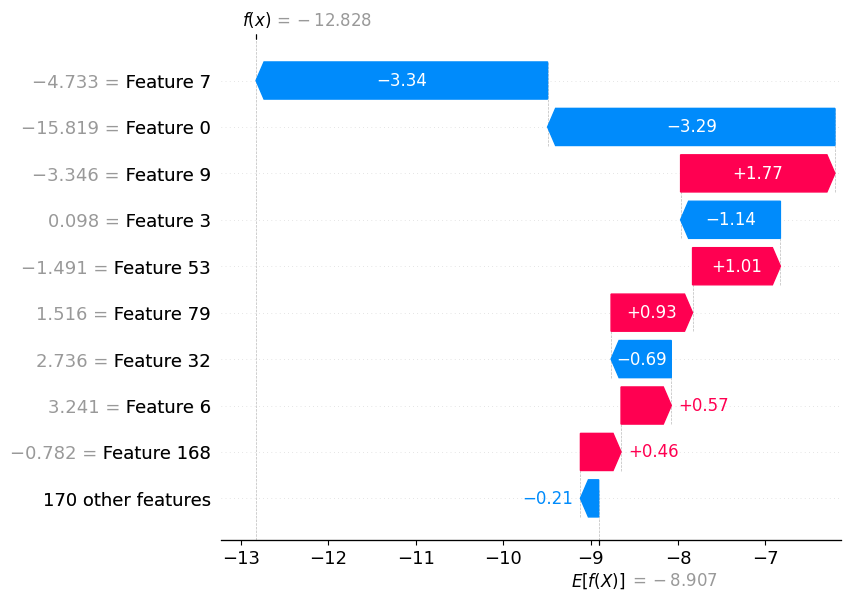

SITTING


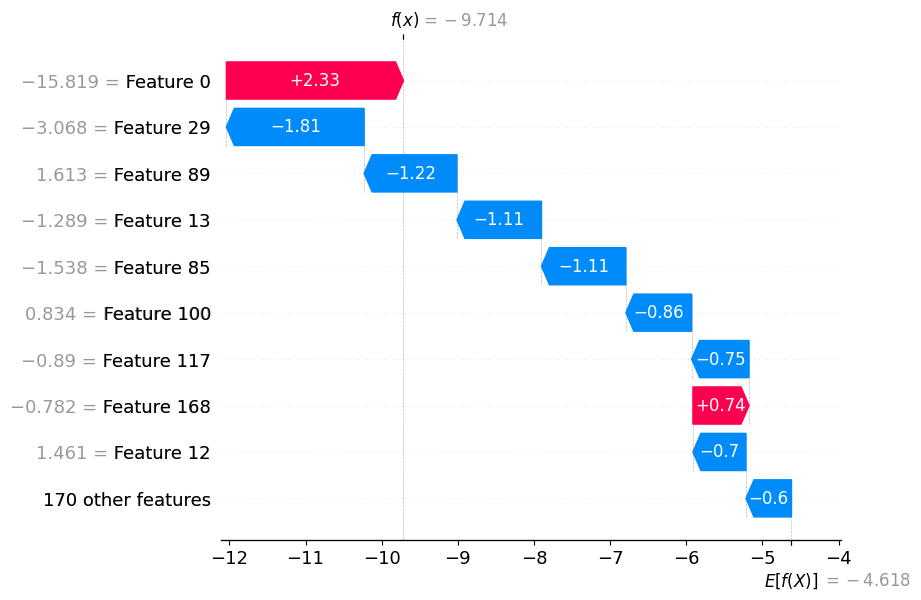

STANDING


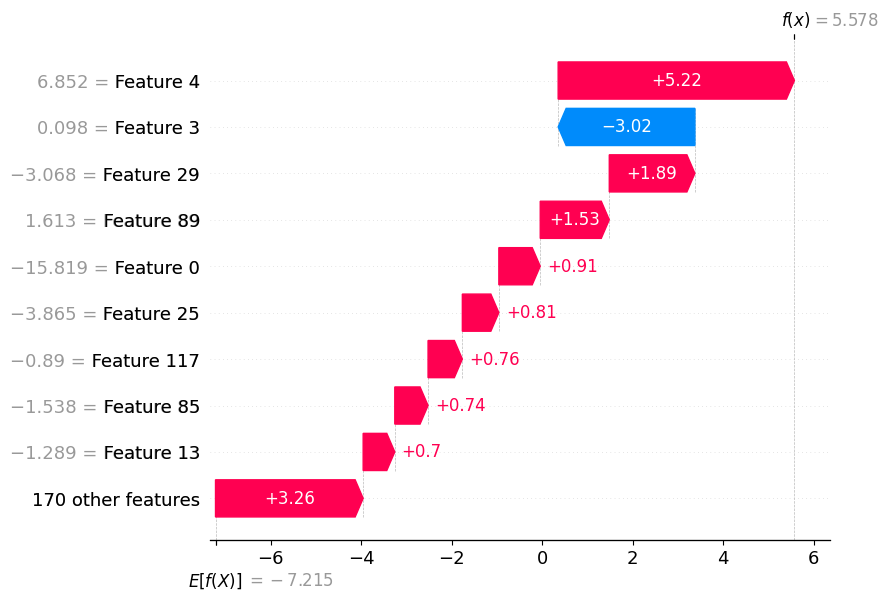

LAYING


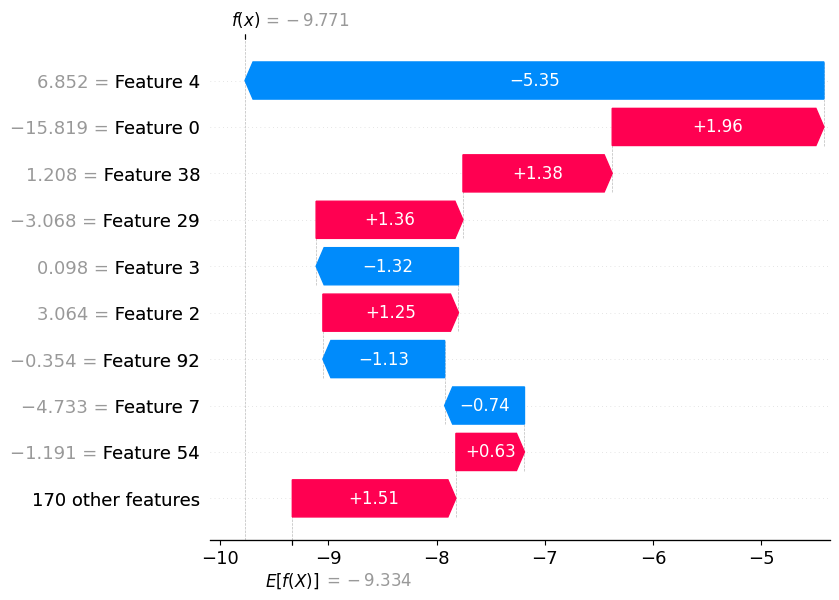

In [ ]:
for class_index in np.arange(6):
    print(activity_labels[class_index + 1])
    shap.plots.waterfall(shap_values[0,:,class_index])

Рассмотрим вклад фичей для всех предсказаний в целом:

WALKING


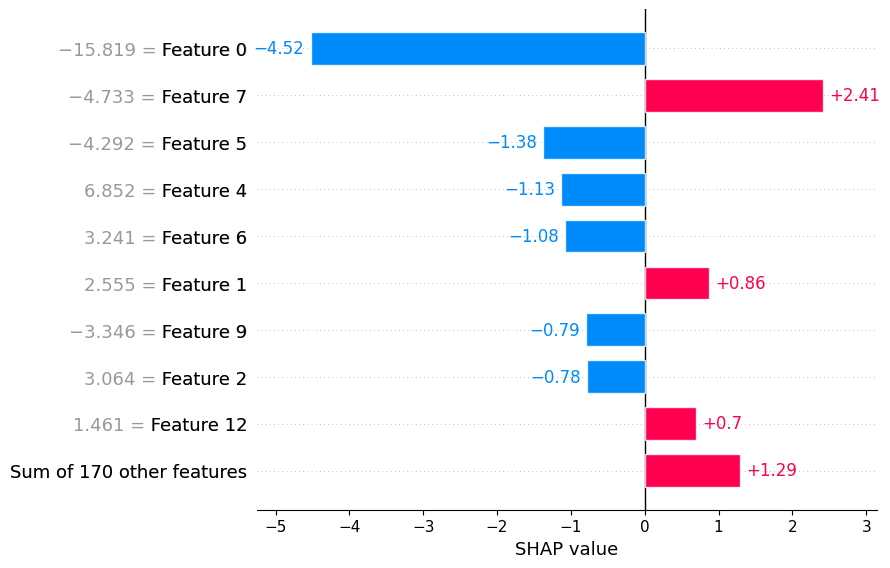

WALKING_UPSTAIRS


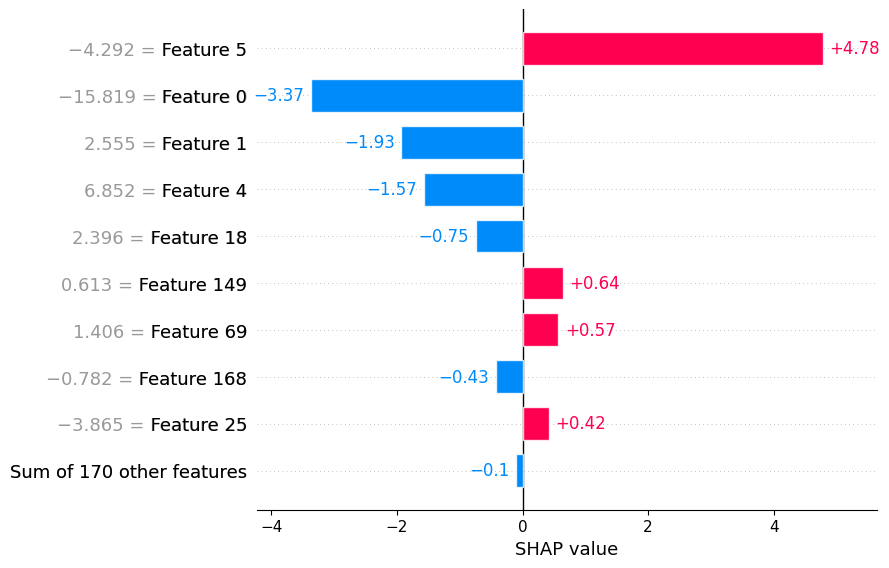

WALKING_DOWNSTAIRS


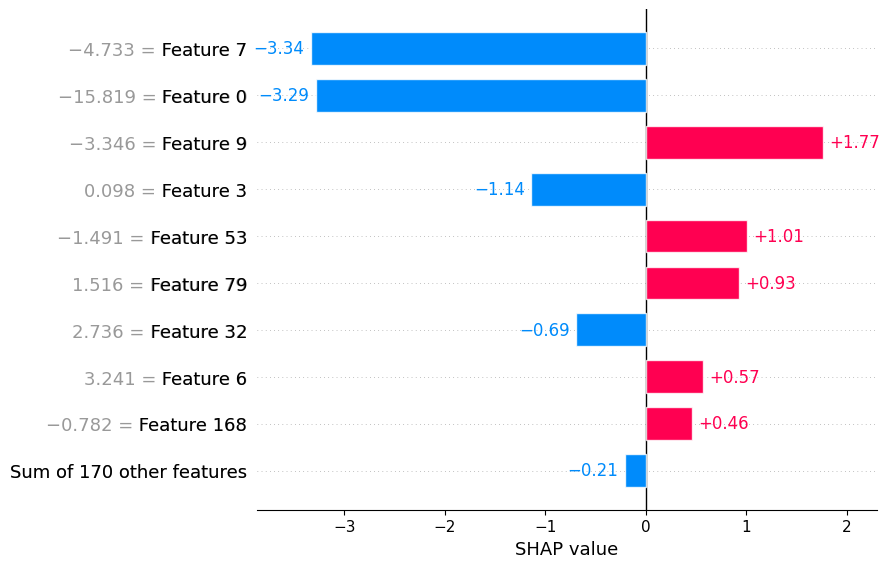

SITTING


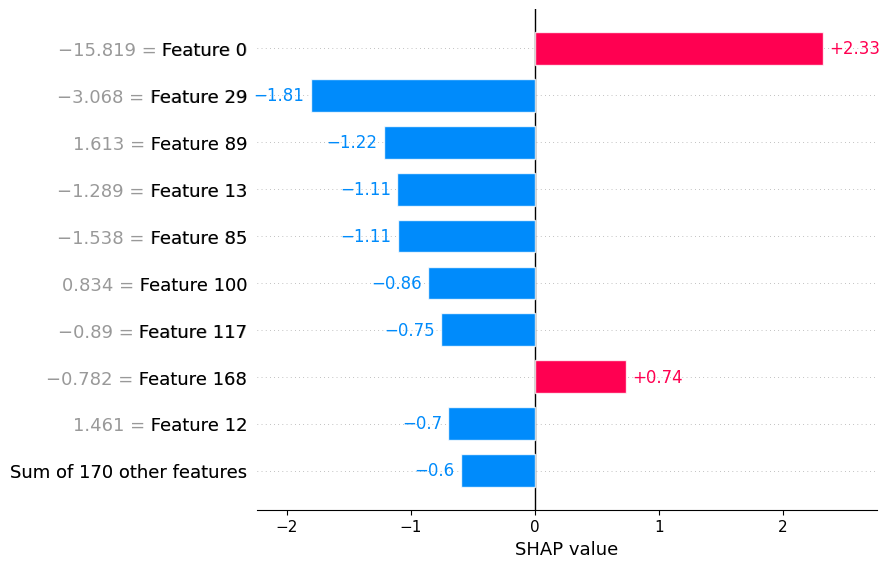

STANDING


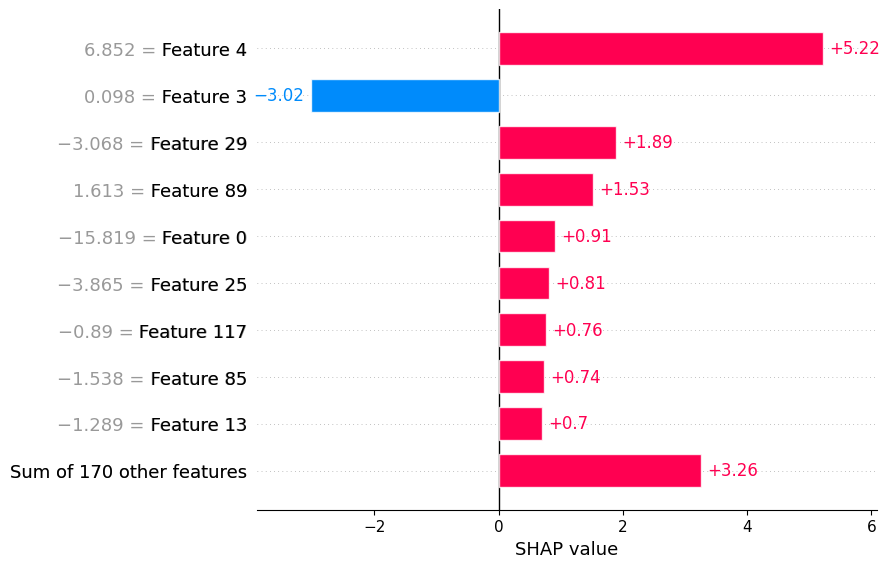

LAYING


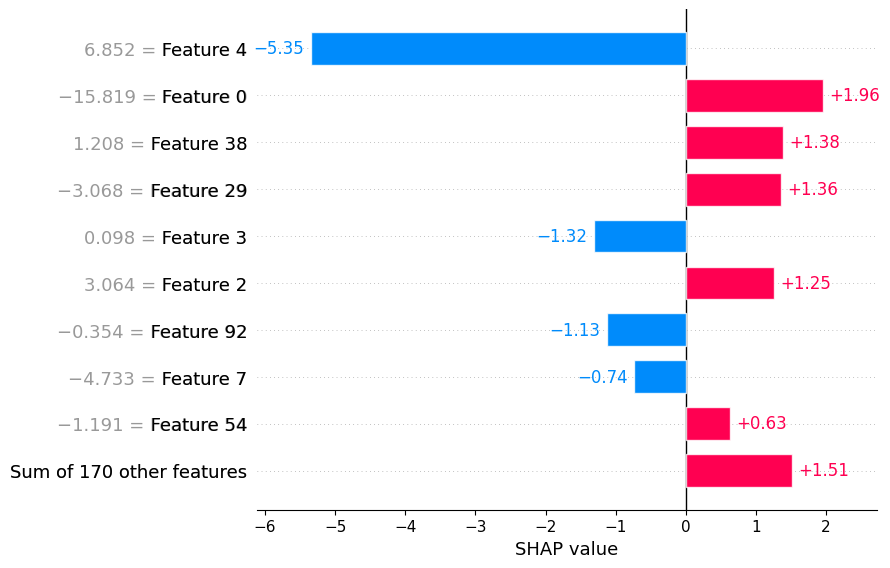

In [ ]:
for class_index in np.arange(6):
    print(activity_labels[class_index + 1])
    shap.plots.bar(shap_values[0,:,class_index])

In [ ]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values.values[:50, :, 0])

WALKING


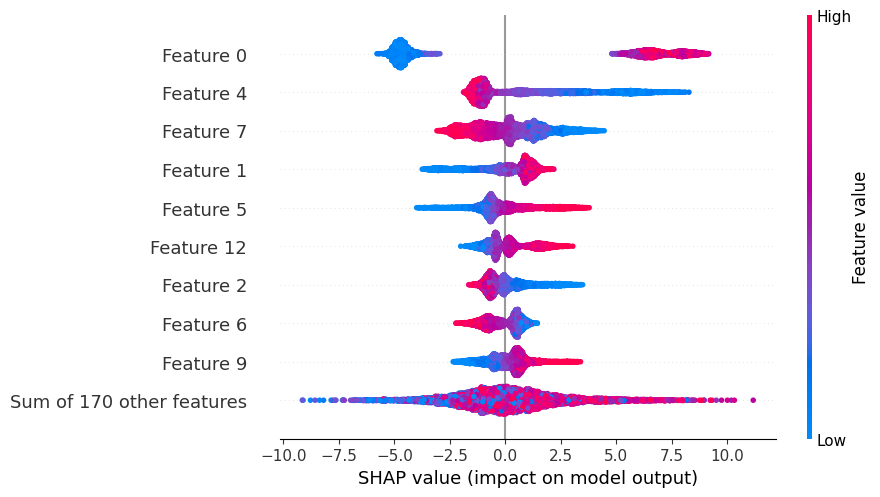

WALKING_UPSTAIRS


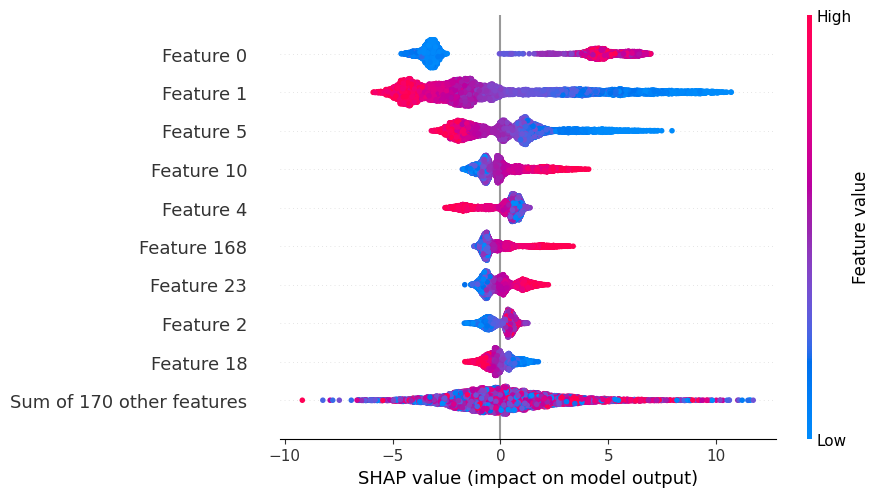

WALKING_DOWNSTAIRS


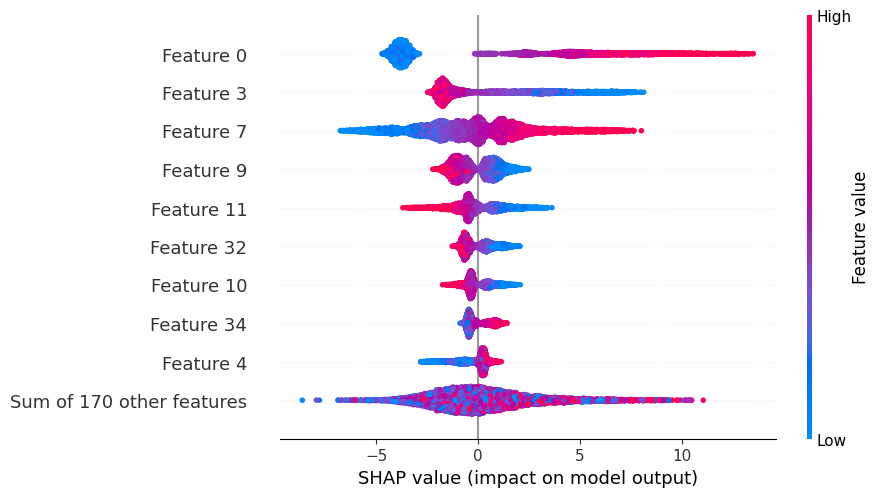

SITTING


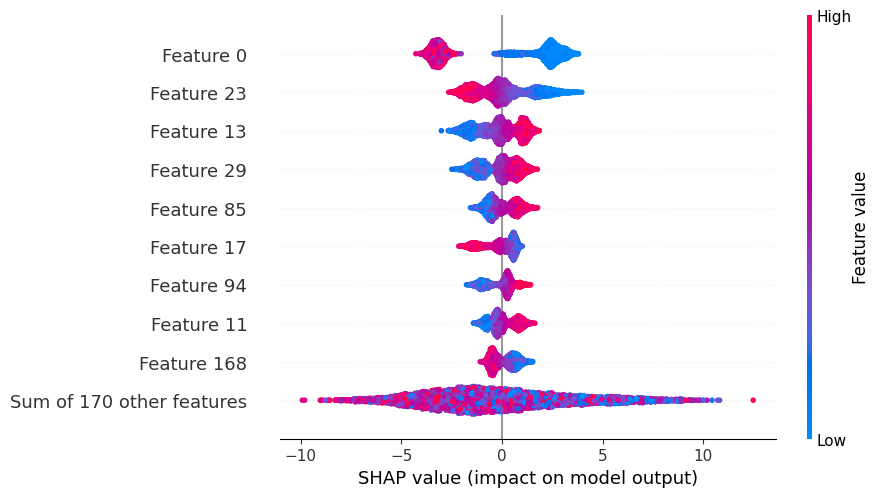

STANDING


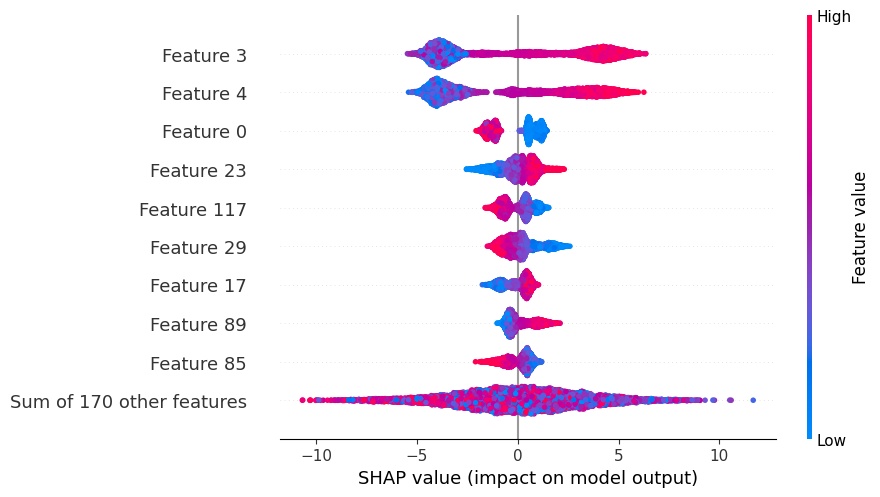

LAYING


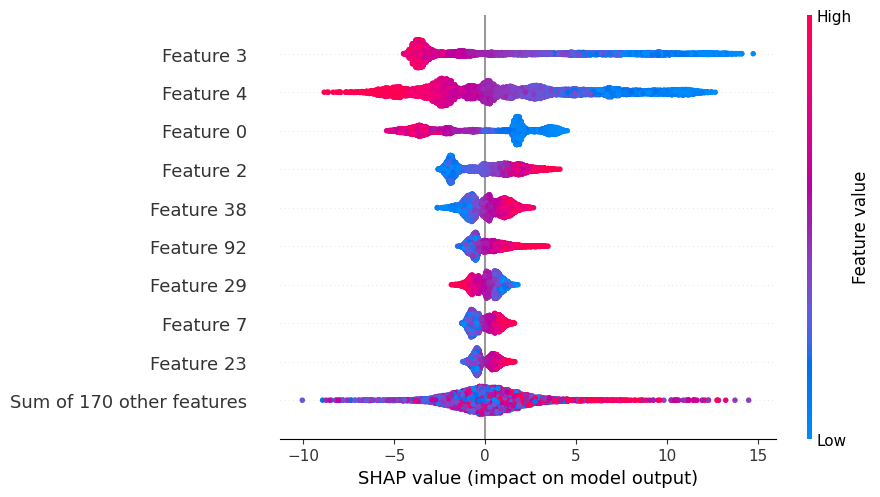

In [ ]:
for class_index in np.arange(6):
    print(activity_labels[class_index + 1])
    shap.plots.beeswarm(shap_values[:,:,class_index])

### Conclusion

Your thoughts about the plots and model behaviour:

...

Видно, что на предсказания модели больше всего влияют фичи 0,3,4,7, 23. В особенности фичи 0 и 4 дают огромный вклад в классы WALKING, WAlKING_DOWNSTAIRS, и STANDING, LAYING соответственно.